In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 12:44:59.227643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 12:45:00.505201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 12000
end_idx = 12500
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(500, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(500, 96, 7)
(336000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(500, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(500, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 12:45:09.262180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 12:45:12.406112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 4ms/step


16/16 [==============================] - 0s 3ms/step


16/16 [==============================] - 0s 3ms/step
CPU time: 7349.999725256115 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

16/16 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.87740193 0.05068564 0.32187191 ... 0.55379802 0.93292345 0.64226437]
Fitness value of the best solution = 0.0011652582195331637


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

16/16 [==============================] - 0s 3ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


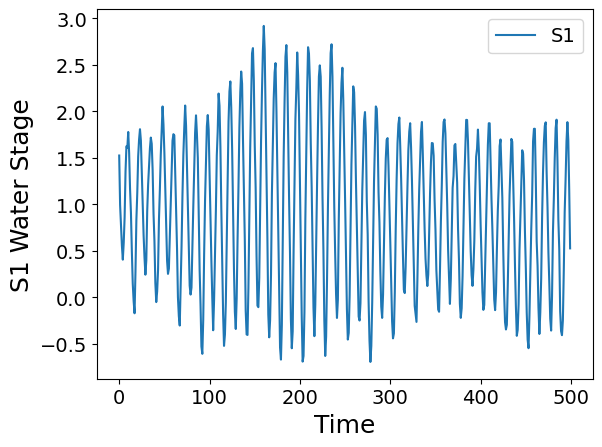

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low15.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.877402,0.050686,0.321872,0.638987,0.763623,0.828890,0.828293,0.565129,0.380556,0.942793,...,0.088849,0.874542,0.030288,0.271303,0.653496,0.905474,0.948656,0.926943,0.612230,0.119490
1,0.983809,0.582025,0.304597,0.902626,0.918001,0.236811,0.093262,0.105772,0.396238,0.518426,...,0.562596,0.130841,0.533084,0.602910,0.905935,0.112033,0.001751,0.518676,0.923093,0.445632
2,0.348552,0.042193,0.957618,0.371215,0.994072,0.898708,0.921604,0.655833,0.072801,0.551527,...,0.088739,0.239413,0.636098,0.116420,0.682547,0.354375,0.024998,0.762362,0.518300,0.435311
3,0.434225,0.000152,0.149068,0.403721,0.295733,0.326083,0.715771,0.368023,0.264734,0.264217,...,0.022411,0.000365,0.399459,0.687067,0.851238,0.398641,0.578433,0.676006,0.848916,0.251735
4,0.035436,0.248551,0.262810,0.365466,0.491217,0.794038,0.699623,0.997466,0.696442,0.968483,...,0.142987,0.373441,0.859539,0.126420,0.766686,0.648983,0.019008,0.467594,0.015989,0.966109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.793550,0.299597,0.614636,0.451221,0.915455,0.183337,0.315481,0.740610,0.509266,0.187389,...,0.847920,0.509483,0.783868,0.252973,0.600086,0.576377,0.866768,0.568025,0.203915,0.935162
496,0.690726,0.907699,0.757272,0.327159,0.187228,0.870966,0.151704,0.620530,0.929284,0.799601,...,0.153153,0.631998,0.129903,0.678189,0.680951,0.013873,0.558333,0.977702,0.936187,0.042615
497,0.526929,0.566863,0.405858,0.383269,0.800947,0.468781,0.183545,0.102767,0.650585,0.619960,...,0.076108,0.645802,0.994895,0.276547,0.627600,0.143346,0.932173,0.878728,0.453841,0.132556
498,0.282950,0.656175,0.060245,0.326011,0.554502,0.773720,0.417996,0.966602,0.455119,0.052004,...,0.387205,0.457095,0.015531,0.448951,0.539254,0.168719,0.841340,0.749504,0.591920,0.056501


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low15.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.523946,1.447075,1.577788,1.596660,1.117354,1.129492,1.176470,1.136398,0.870730,1.160919,...,1.399720,1.502355,1.424981,1.484040,1.564564,1.584437,1.732140,1.688836,1.854094,1.928385
1,0.991548,0.851274,0.928259,0.923216,0.755841,0.913874,0.717768,0.753725,0.561719,0.522125,...,1.461630,1.624618,1.632599,1.814548,1.731459,1.824508,1.555717,1.675375,1.574507,1.638112
2,0.765179,0.497882,0.822650,0.775174,0.591697,0.767812,0.554353,0.592268,0.389880,0.479763,...,1.706256,1.814284,1.530441,1.588547,1.684129,1.731926,1.243493,1.210879,1.396019,1.440414
3,0.553437,0.493583,0.587408,0.537916,0.486585,0.288840,0.422114,0.431087,0.494951,0.659017,...,1.641060,1.738149,1.226781,1.250274,1.406966,1.472050,0.970083,1.166097,1.236906,1.209621
4,0.404508,0.709939,0.465169,0.374732,0.578874,0.662628,0.607048,0.585958,0.894922,0.936305,...,1.210472,1.233382,0.946066,1.030373,1.089283,1.143159,0.713108,0.757394,0.903610,0.938709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.673285,1.592772,1.611208,1.659357,1.840623,1.680401,1.739051,1.865397,1.691425,1.694987,...,0.136175,0.173909,0.723602,0.924648,0.772729,0.833092,1.123493,1.148200,1.120513,1.325357
496,1.882720,2.108716,1.987238,2.072703,1.521581,1.841571,1.505950,1.596172,1.195961,1.216181,...,0.798701,0.834971,1.074162,1.307374,1.048143,1.128360,1.548944,1.537817,1.459602,1.640819
497,1.687593,1.725280,1.770001,1.787431,1.171714,1.448504,1.211094,1.299278,0.605493,0.962888,...,1.049466,1.251619,1.526239,1.469834,1.432430,1.593181,1.728140,1.734086,1.722132,1.831352
498,1.159496,1.138011,1.281314,1.327220,0.694447,0.854759,0.847080,0.835427,0.211557,0.586779,...,1.506663,1.633530,1.676971,1.765742,1.700753,1.825606,1.740617,1.826347,1.742478,1.887825


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 5205, areas: 1082.468654491513


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

16/16 [==============================] - 0s 3ms/step
time steps: 0, areas: 0
time steps: 10503, areas: 3132.795587439676
